# Семинар №5

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.units import action

/home/evgeniy/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

# Особые точки

Настало время перейти к более продвинутым методам сравнения изображений. На прошлых занятих мы рассматривали методы, которые базировались больше на глобальных признаках изображения. Однако, для того, чтобы исследовать схожесть неких изображений, недостаточно иметь представление только о глобальных признаках. В качестве шага в определении локальных признаков мы рассматривали метод "скользящего окна". 

Итак, введем предположение, что на изображении можно найти локальные признаки в некой окрестности __ключевой точки__. Вопрос: что брать за ключевую точку и какую окрестность брать?

Для начала разберемся, почему глобальные признаки иногда работают плохо на примере следующих изображений.

<img src="https://i.ibb.co/6FFHWd5/image--000.jpg" alt="Drawing" style="width: 600px;"/> 

Из всего этого вытекает идея - хочется как-то выделить точки их окрестности, к которым можно привязаться для сравнения. 

## Сравнение изображений при помощи локальных признаков: основные шаги

1. Локализация особых точек


2. Выделение особых фрагментов – окрестностей ключевых точек, инвариантных к различного рода преобразованиям


3. Построение векторов признаков для найденных фрагментов


4. Сопоставление наборов локальных признаков для двух изображений
    
<img src="https://i.ibb.co/fD6fRDJ/image--007.jpg" alt="Drawing" style="width: 400px;"/> 

Методов поиска и описания контрольных точек очень много, мы рассмотрим только некоторые

В 2020 году проводили сравнение некоторых методов по производительности, по этой работе можно оценить количество различных алгоритмов:
https://arxiv.org/pdf/2007.10000v2
<img src="img/comparison.png" alt="Drawing" style="width: 1000px;"/> 

Также есть описание многих алгоритмов
https://www.researchgate.net/publication/356709780_A_Review_of_Keypoints'_Detection_and_Feature_Description_in_Image_Registration

# Harris Corner Detection

[документация](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga4055896d9ef77dd3cacf2c5f60e13f1c)

Harris Corner Detector - это оператор обнаружения углов. Впервые он был представлен Крисом Харрисом и Майком Стивенсом в 1988 году после усовершенствования углового детектора Моравека . По сравнению с предыдущим, детектор углов Харриса учитывает разницу угловых оценок напрямую по отношению к направлению, вместо использования смещаемых на 45 градусов участков. Было доказано, что он более точен при различении краев и углов. С тех пор он был улучшен и принят во многие алгоритмы для предварительной обработки изображений для последующих приложений.


Без потери общности мы будем предполагать, что используется двухмерное изображение в градациях серого. Пусть это изображение будет задано как I. Возьмем фрагмент изображения (окно) и сдвинем его на u, v. Сумма квадратов разностей (SSD) между этими двумя патчами, обозначенная E, определяется как:

$$E(u,v) = \sum_{x,y} \underbrace{w(x,y)}_\text{window function} \, [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2$$

Оконная функция $w(x,y)$ - это либо прямоугольное окно, либо гауссово окно, которое дает вес пикселям внизу. 
Мы должны максимизировать функцию $E(u, v)$ для обнаружения углов. 
Можно перейти к матричной записи:

<img src="img/harr_eq.png" alt="Drawing" style="width: 600px;"/> 


Здесь $I_x$ и $I_y$ являются производными изображения в направлениях $x$ и $y$ соответственно.

Теперь, чтобы определить, является ли точка углом, нужно посчитать следующую величину R:
$$R = det(M) - k(trace(M))^2$$ 
где

1. $\lambda_1$ и $\lambda_2$ - собственные значения $M$
2. $trace (M) = \lambda_1 + \lambda_2$
3. $det (M) = \lambda_1 \lambda_2$
4. k - эмпирическая константа 0.04-0.06

Таким образом, значения этих собственных значений определяют, является ли область угловой, кромочной или плоской.

1. Когда $|R|$ маленький, что случается, когда $\lambda_1$ и $\lambda_2$ маленькие, область плоская.
2. Когда $R<0$, что происходит, когда $\lambda_1 >> \lambda_2$ или наоборот, область является контуром (границей).
3. Когда $R$ большое, что происходит, когда $\lambda_1$ и $\lambda_2$ большие и $\lambda_1 \sim \lambda_2$, регион является углом.

На картинке это можно представить следующим образом:
<img src="img/fig.jpg" alt="Drawing" style="width: 600px;"/> 

<img src="img/lambda.png" alt="Drawing" style="width: 600px;"/> 

[ссылка на видео](https://www.youtube.com/watch?v=Z_HwkG90Yvw&t=540s&ab_channel=FirstPrinciplesofComputerVision)

## Harris Corner Detector in OpenCV
Для этой цели в OpenCV есть функция ```cv2.cornerHarris(img, blockSize, ksize, k)```. Его аргументы:

1. **img** - входное изображение, оно должно быть в градациях серого и иметь тип float32.
2. **blockSize** - это размер окрестности, рассматриваемой для обнаружения угла
3. **ksize** - параметр апертуры используемого оператора Собеля (Это размер ядра Собеля, используемого для получения производных изображения)
4. **k** - свободный параметр детектора Харриса в уравнении.

Результат функции:
$dst(x,y)=detM(x,y)−k⋅(trM(x,y))2$

<img src="https://masters.donntu.ru/2008/kita/logvinova/library/f10.jpg" alt="Drawing" style="width: 400px;"/> 

In [5]:
fname = 'img/lk.jpg'
image = cv2.imread(fname)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

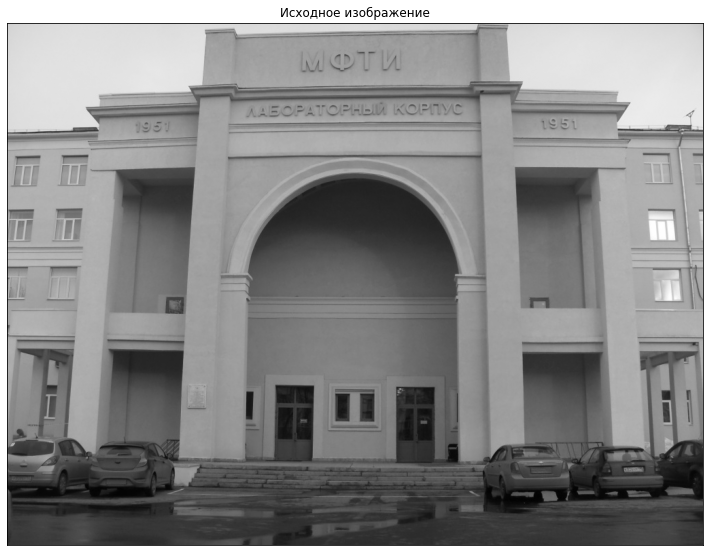

In [6]:
plot_one_image(gray, is_gray=True)

In [7]:
dst = cv2.cornerHarris(gray, blockSize=3, ksize=3, k=0.14)
dst = cv2.dilate(dst, None)  # расширение

print(f'Размер изображения: {image.shape}, \nразмер результата dst: {dst.shape}')

Размер изображения: (768, 1024, 3), 
размер результата dst: (768, 1024)


In [8]:
dst.shape

(768, 1024)

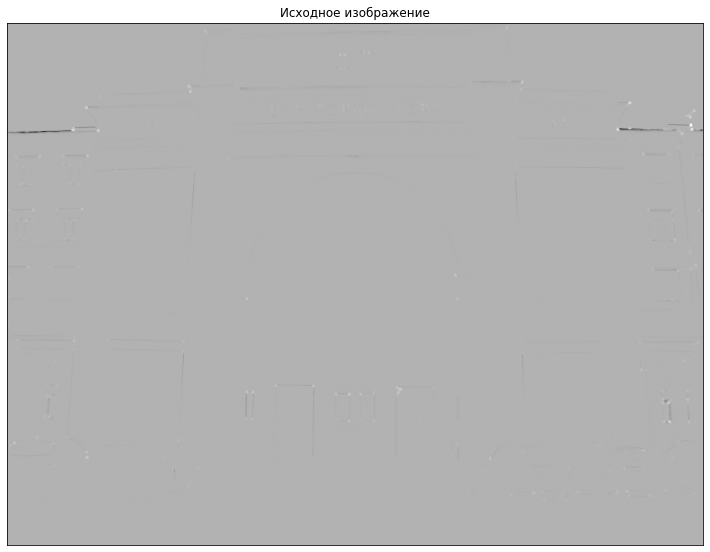

In [9]:
plot_one_image(dst, is_gray=True)

In [10]:
# нормировка значений
dst_normed = (dst - dst.min()) / (dst.max() - dst.min())

In [12]:
print(np.max(dst_normed), np.min(dst_normed))

1.0 0.0


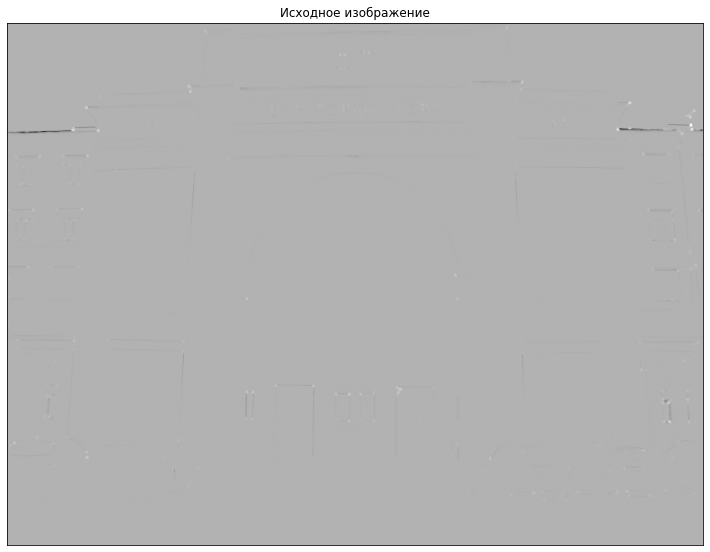

In [13]:
# Карта углов
plot_one_image(dst_normed, is_gray=True)

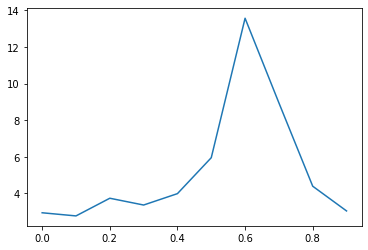

In [14]:
hist, bins = np.histogram(dst_normed.flatten(), 10, [0., 1.0])

plt.plot(bins[:-1], np.log(hist))
plt.show()

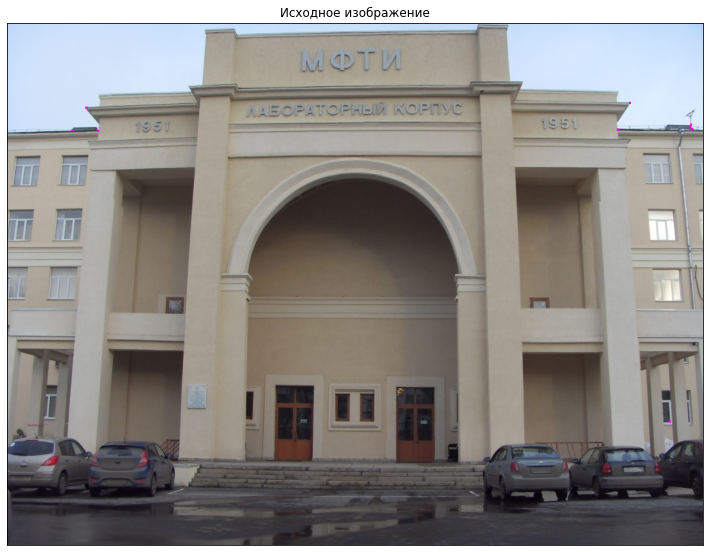

In [15]:
# Порог для оптимального значения, он может варьироваться в зависимости от изображения
draw_image = image.copy()
draw_image[dst_normed > 0.8] = [255, 0, 255]

plot_one_image(draw_image)

Рассмотрим [```cv2.cornerEigenValsAndVecs```](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga3dbce297c1feb859ee36707e1003e0a8)

Рассчитывает минимальное собственное значение градиентных матриц для определения угла.

Функция аналогична функции ```cv2.cornerHarris```, но вычисляет и сохраняет только собственное минимальное значение ковариационной матрицы производных, т.е. min(λ1,λ2) в терминах формул в описании [cornerEigenValsAndVecs](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga4055896d9ef77dd3cacf2c5f60e13f1c).

In [16]:
dst = cv2.cornerEigenValsAndVecs(gray, blockSize=3, ksize=1)

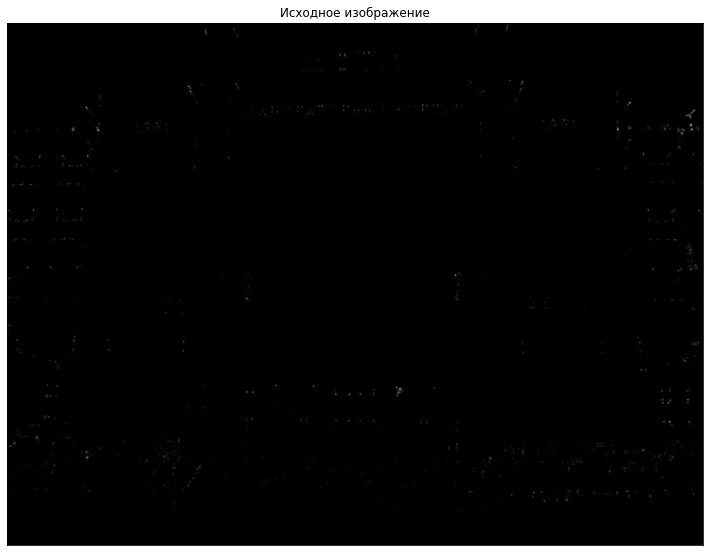

In [17]:
dst = cv2.cornerMinEigenVal(gray, 3, 0.1)
dst_normed = (dst - dst.min()) / (dst.max() - dst.min())
plot_one_image(dst_normed, is_gray=True)

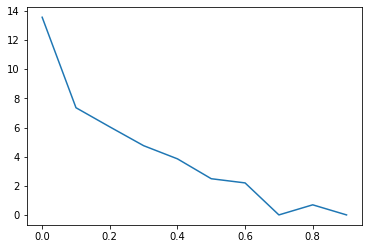

In [18]:
hist, bins = np.histogram(dst_normed.flatten(), 10, [0., 1.0])

plt.plot(bins[:-1], np.log(hist))
plt.show()

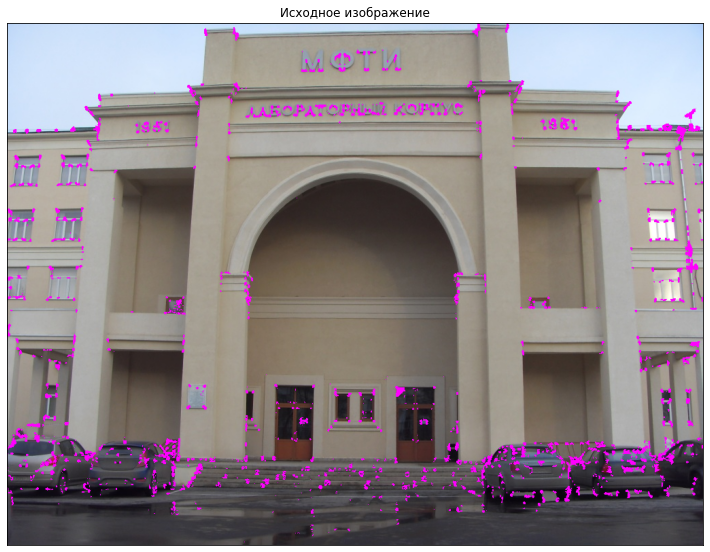

In [19]:
# Threshold for an optimal value, it may vary depending on the image.
draw_image = image.copy()
draw_image[dst_normed > 0.01] = [255, 0, 255]

plot_one_image(draw_image)

# Shi-Tomasi Corner Detector & Good Features to Track
В прошлой главе мы увидели детектор углов Харриса. Позже в 1994 году Дж. Ши и К. Томази внесли небольшую модификацию в свою статью Good Features to Track, которая показывает лучшие результаты по сравнению с детектором Harris Corner Detector. Оценочную функцию в Harris Corner Detector предоставили:

$$R = \lambda_1 \lambda_2 - k(\lambda_1+\lambda_2)^2$$

Вместо этого Ши-Томаси предложил:

$$R = min(\lambda_1, \lambda_2)$$

Если оно больше порогового значения, оно рассматривается как угол. Если мы построим его в пространстве $\lambda_1 - \lambda_2$, как мы это делали в Harris Corner Detector, мы получим изображение, как показано ниже:

<img src="https://i.ibb.co/sCBQZVp/shitomasi_space.png" alt="Drawing" style="width: 400px;"/> 


Из рисунка видно, что только когда $\lambda_1$ и $\lambda_2$ превышают минимальное значение $\lambda_ {min}$, оно считается углом (зеленая область).

## Shi-Tomasi Corner Detector in OpenCV

OpenCV имеет функцию ```cv2.goodFeaturesToTrack()```. Он находит N самых сильных углов на изображении методом Ши-Томази (или Обнаружение углов Харриса, если вы его укажете). Как обычно, изображение должно быть в градациях серого. Затем вы указываете количество углов, которые вы хотите найти. После нужно указать уровень качества, который является значением в диапазоне 0-1, что обозначает минимальное качество угла, ниже которого все отклоняются. Затем мы устанавливаем минимально возможное евклидово расстояние между обнаруженными углами.

Со всей этой информацией функция находит углы на изображении. Все углы ниже уровня качества отклоняются. Затем сортирует оставшиеся углы по качеству в порядке убывания. Затем функция занимает первый самый сильный угол, отбрасывает все близлежащие углы в диапазоне минимального расстояния и возвращает N самых сильных углов.

```cv2.goodFeaturesToTrack(InputArray: image, OutputArray: corners, int: maxCorners, double: qualityLevel, double: minDistance,
InputArray: mask = noArray(), int: blockSize = 3, bool: useHarrisDetector = false, double: k = 0.04 )```


1. **image** - Входное 8-битное или 32-битное изображение с плавающей точкой, одноканальное.
2. **corners** - Выходной вектор обнаруженных углов.
3. **maxCorners** - Максимальное количество углов для возврата. Если углов больше, чем найдено, возвращается самый сильный из них. maxCorners <= 0 подразумевает, что не установлено ограничение на максимальное и все обнаруженные углы возвращаются.
4. **qualityLevel** - Параметр, характеризующий минимально допустимое качество углов изображения. Значение параметра умножается на величину наилучшего качества угла, которое является минимальным собственным значением ([см. cornerMinEigenVal](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga3dbce297c1feb859ee36707e1003e0a8)) или откликом функции Harris ([см. cornerHarris](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)). Углы с мерой качества меньше, чем изделие, отбраковываются. Например, если лучший угол имеет меру качества = 1500, а уровень качества - 0,01, то все углы с мерой качества меньше 15 забраковываются.
5. **minDistance** - Минимально возможное евклидовое расстояние между возвращаемыми углами.
6. **mask** - Необязательный регион, представляющий интерес. Если изображение не пустое (оно должно иметь тип CV_8UC1 и тот же размер, что и изображение), то оно указывает регион, в котором обнаружены углы.
7. **blockSize** - Размер среднего блока для вычисления производной ковариационной матрицы над каждым пикселем окрестности. [См. cornerEigenValsAndVecs](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga4055896d9ef77dd3cacf2c5f60e13f1c).
9. **useHarrisDetector** - Параметр, указывающий, использовать ли детектор Harris (см. уголHarris) или уголMinEigenVal.
10. **k** - Свободный параметр детектора Harris.

In [221]:
# Найти углы
corners = cv2.goodFeaturesToTrack(gray, maxCorners=200, qualityLevel=0.01, minDistance=30, mask=None, blockSize=3, \
                                  gradientSize=11, useHarrisDetector=False, k=0.5)
corners = np.intp(corners)  # Конвертировать в int

print(corners[:5])

[[[1005  151]]

 [[ 899  157]]

 [[ 132  158]]

 [[ 934  628]]

 [[ 118  125]]]


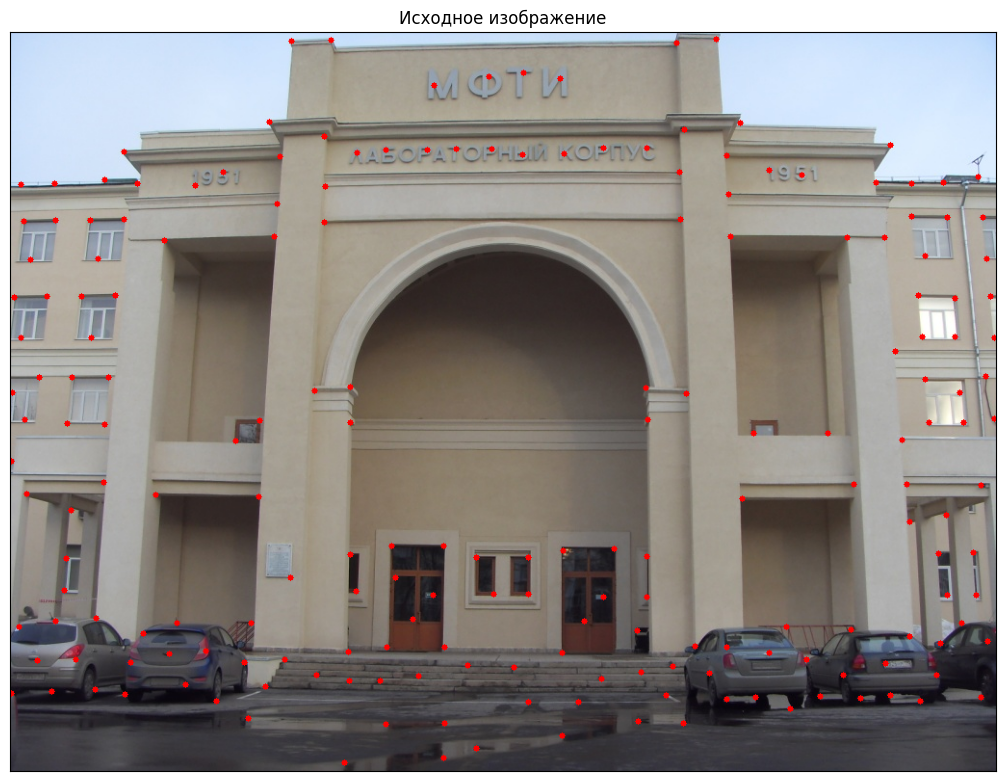

In [222]:
draw_image = image.copy()
# Отрисуем найденные точки
for i in corners:
    x, y = i.ravel()
    cv2.circle(draw_image, (x, y), 3, 255, -1)

plot_one_image(draw_image)

# Introduction to SIFT (Scale-Invariant Feature Transform)

[ссылка на статью](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)

[ссылка на объяснения алгоритма](http://weitz.de/sift/)


[ссылка на documentation](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html)

В последних двух главах мы видели некоторые детекторы углов, такие как Харрис и т. д. Они не зависят от вращения, что означает, что даже если изображение поворачивается, мы можем найти те же углы. Это очевидно, потому что углы остаются и в повернутом изображении. Но как насчет масштабирования? Угол может не быть углом, если изображение масштабировано. Например, проверьте простое изображение ниже. Угол на небольшом изображении в небольшом окне является плоским, когда он увеличен в том же окне. Так что угол Харриса не является инвариантным к масштабу.

<img src="https://i.ibb.co/N7kR8Lc/sift_scale_invariant.jpg" alt="Drawing" style="width: 400px;"/> 

Рассмотрим новый алгоритм Scale Invariant Feature Transform (SIFT), который позволяет сохранить инвариантость к масштабированию.



## Обнаружение экстремумов в пространстве

Из рисунка выше видно, что мы не можем использовать одно и то же окно для обнаружения ключевых точек с разным масштабом. Это нормально с небольшим углом. Но чтобы обнаружить большие углы, нам нужны большие окна. Для этого используется масштабная фильтрация. В нем находится гауссовский лапласиан для изображения с различными значениями $\sigma$. LoG действует как детектор капель, который обнаруживает капли разных размеров из-за изменения $\sigma$. Короче говоря, $\sigma$ действует как параметр масштабирования. Например, на изображении выше, ядро Гаусса с низким значением $\sigma$ дает высокое значение для небольшого угла, в то время как ядро гауссиана с высоким значением $\sigma$ хорошо подходит для большего угла. Таким образом, мы можем найти локальные максимумы по шкале и пространству, которые дают нам список значений $(x, y, \sigma)$, что означает, что существует потенциальная ключевая точка в точке $(x, y)$ в масштабе $\sigma$.

Но этот LoG не является эффективным, поэтому алгоритм SIFT использует разность гауссианов, которая является приближением LoG. Разность по Гауссу получается как разница по размытию по Гауссу изображения с двумя разными $\sigma$, пусть это будут $\sigma$ и $k \sigma$. Этот процесс выполняется для разных октав изображения в гауссовой пирамиде. Это представлено на изображении ниже:

<img src="https://i.ibb.co/WWyXGrD/sift_dog.jpg" alt="Drawing" style="width: 400px;"/>

Как только DoG найдена, изображения ищут локальные экстремумы в масштабе и пространстве. Например, один пиксель в изображении сравнивается с его 8 соседями, а также с 9 пикселями в следующем масштабе и 9 пикселями в предыдущих масштабах. Если он - локальный экстремум, то это потенциальная ключевая точка. Это означает, что контрольная точка лучше всего представлена в этом масштабе. Посмотрите на рисунке ниже:

<img src="https://i.ibb.co/2YN6FZ6/sift_local_extrema.jpg" alt="Drawing" style="width: 300px;"/>

Что касается различных параметров, в статье приведены некоторые эмпирические данные: число $octaves = 4$, количество уровней $scale = 5$, начальные $\sigma = 1.6$, $k = \sqrt {2}$ и т. д. Их можно использовать в качестве оптимальных значений.



## Локализация ключевых точек

<img src="img/problem.png" alt="Drawing" style="width: 500px;"/>


В приведенном выше выражении D представляет собой разницу Гаусса. Чтобы удалить нестабильные ключевые точки, вычисляется значение x', и если значение функции в точке x' ниже порогового значения, то точка исключается.
<img src="img/filtering.png" alt="Drawing" style="width: 500px;"/>


Рисунок: до и после фильтрации КТ

<img src="img/ref.jpeg" alt="Drawing" style="width: 500px;"/>



## Назначение ориентации

Чтобы добиться обнаружения, инвариантного относительно вращения изображения, необходимо рассчитать ориентацию ключевых точек. Это делается путем рассмотрения окрестности ключевой точки и расчета величины и направления градиентов окрестности. На основе полученных значений строится гистограмма с 36 ячейками, представляющими 360 градусов ориентации (10 градусов на ячейку)(It is weighted by gradient magnitude and gaussian-weighted circular window with σ equal to 1.5 times the scale of keypoint). Таким образом, если направление градиента определенной точки составляет, скажем, 67,8 градусов, в бин, представляющий 60-70 градусов, добавляется значение, пропорциональное величине градиента этой точки. Пики гистограммы выше 80 % преобразуются в новую ключевую точку и используются для определения ориентации исходной ключевой точки.
## Дескриптор ключевой точки

Наконец, для каждой ключевой точки создается дескриптор с использованием окрестности ключевых точек. Эти дескрипторы используются для сопоставления ключевых точек на изображениях. Окрестность ключевой точки размером 16×16 используется для определения дескриптора этой ключевой точки. Этот район размером 16×16 разделен на подблоки. Каждый такой подблок представляет собой непересекающуюся, непрерывную окрестность размером 4×4. Впоследствии для каждого субблока создается ориентация из 8 ячеек аналогично тому, как описано в разделе «Назначение ориентации». Эти 128 значений ячеек (16 подблоков * 8 ячеек на блок) представлены как вектор для генерации дескриптора ключевой точки.

<img src="img/descr.png" alt="Drawing" style="width: 500px;"/>

## Сопоставление ключевых точек 

Ключевые точки между двумя изображениями сопоставляются путем определения ближайших соседей. Но в некоторых случаях второй ближайший матч может быть очень близко к первому. Это может произойти из-за шума или по другим причинам. В этом случае берется отношение ближайшего расстояния ко второму ближайшему расстоянию. Если оно больше 0,8, они отклоняются. Это устраняет около 90% ложных совпадений, в то время как отбрасывает только 5% правильных совпадений, согласно статье.

Так что это краткое изложение алгоритма SIFT. Для получения более подробной информации и понимания, чтение оригинальной статьи настоятельно рекомендуется.

In [223]:
# Step 1: Detect the keypoints using SIFT Detector
detector = cv2.SIFT_create(nfeatures=500, nOctaveLayers=5, contrastThreshold=0.07, \
                                       edgeThreshold=10, sigma=1.3)

keypoints = detector.detect(image, None)

image2 = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2))

keypoints2 = detector.detect(image, None)

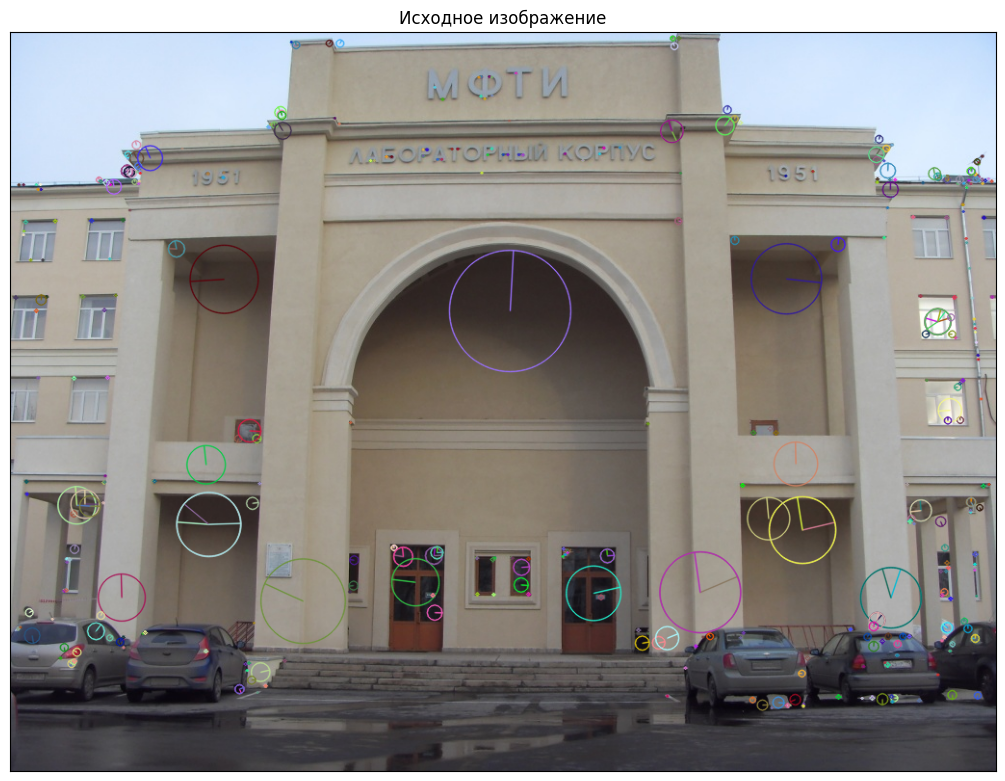

In [224]:
# Draw keypoints
draw_image = image.copy()
img_keypoints = np.empty((image.shape[0], image.shape[1], 3), dtype=np.uint8)
cv2.drawKeypoints(draw_image, keypoints, img_keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Show detected (drawn) keypoints
plot_one_image(img_keypoints)

##  Поиск объектов 

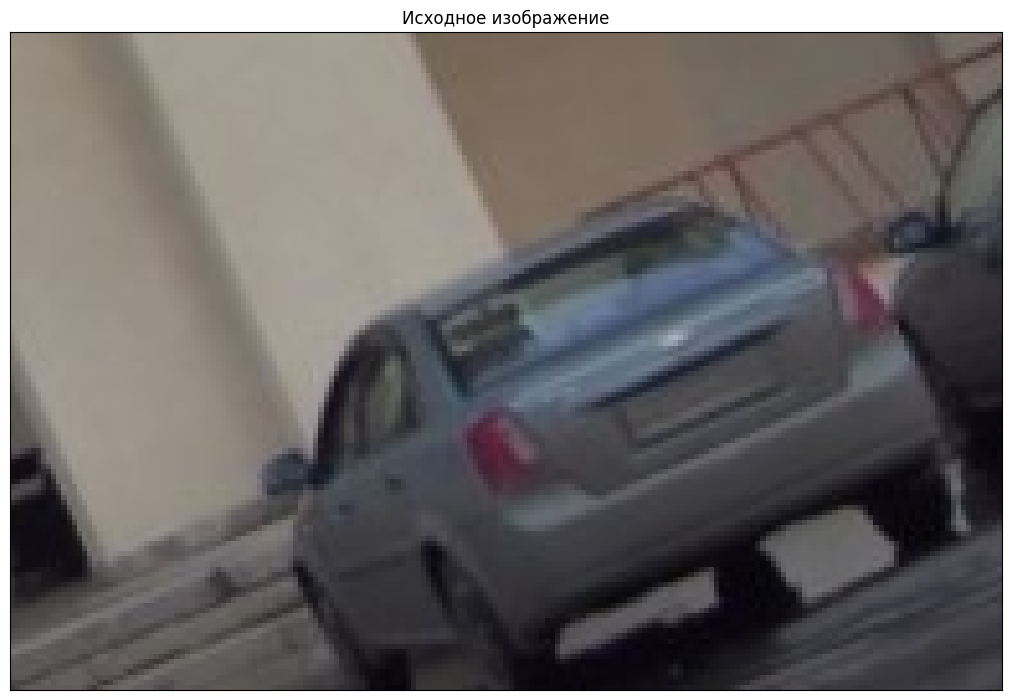

In [225]:
img_car = cv2.imread('img/crop_lk.jpg')
img_car = cv2.cvtColor(img_car, cv2.COLOR_BGR2RGB)

plot_one_image(img_car)

In [226]:
import skimage.exposure

In [227]:
img_car_new = skimage.exposure.adjust_gamma(img_car, gamma=1.7)

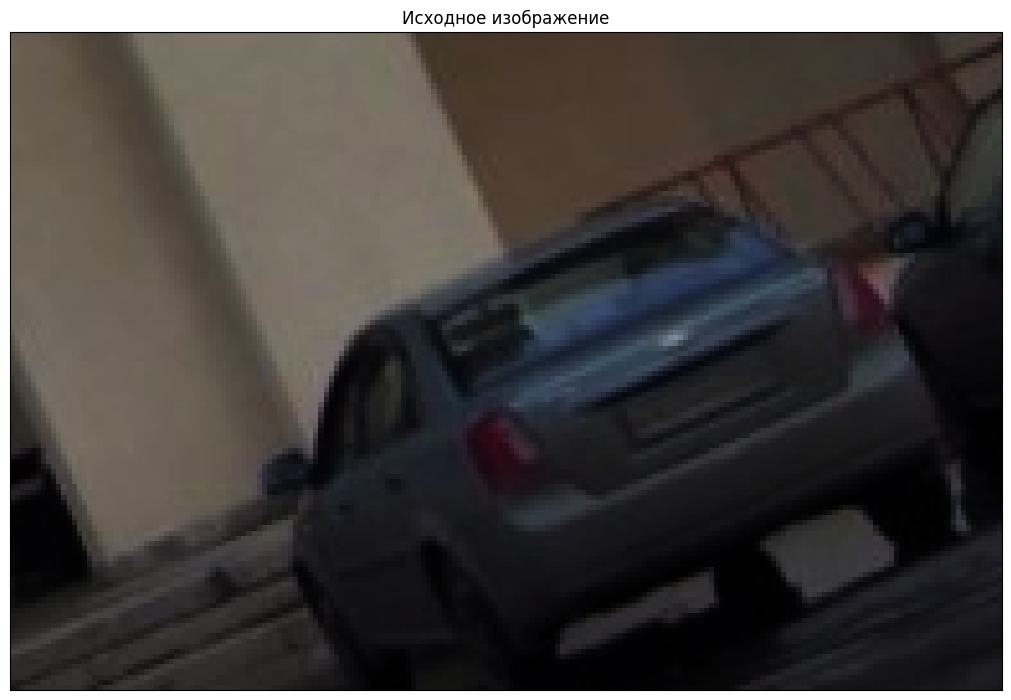

In [228]:
plot_one_image(img_car_new)

### Поиск особых точек и их дескрипторов

In [229]:
# Step 1: Detect the keypoints using SURF Detector
hyp_params = dict(
    nfeatures = 100,
    nOctaveLayers = 3,
    contrastThreshold = 0.03,
    edgeThreshold = 10,
    sigma = 1.6)  # hyp params

detector = cv2.SIFT_create(**hyp_params)

# detector = cv2.ORB_create()

In [230]:
image.shape, img_car.shape

((768, 1024, 3), (128, 193, 3))

In [231]:
# calculate feature points and they descriptors
%time keypoints1, desc1 = detector.detectAndCompute(image, None)
%time keypoints2, desc2 = detector.detectAndCompute(img_car, None)

CPU times: total: 297 ms
Wall time: 91 ms
CPU times: total: 0 ns
Wall time: 3.98 ms


In [232]:
desc2.shape

(100, 128)

### Сопоставление особых точек

Классические дескрипторы признаков (SIFT, SURF, ...) обычно сравниваются и сопоставляются с помощью евклидового расстояния (или L2-нормы). Поскольку дескрипторы SIFT и SURF представляют собой гистограмму ориентированного градиента (вейвлет-ответа Хаара для SURF) в окрестности, то альтернативами евклидового расстояния являются метрики, основанные на гистограммах ( χ2, Earth mover's distance (EMD), и тд).

Двоичные дескрипторы (ORB, BRISK, ...) сопоставляются с помощью расстояния Хэмминга. Это расстояние эквивалентно подсчету количества различных элементов для двоичных строк (подсчет населения после применения операции XOR): $D_{hamming}(a,b)=\sum_{i=0}^{n−1} a_i⊕b_i$

Для фильтрации совпадений Lowe предложил в использовать тест соотношения расстояний, чтобы попытаться устранить ложные совпадения. Вычисляется соотношение расстояний между двумя ближайшими совпадениями рассматриваемой ключевой точки, и это хорошее совпадение, когда это значение ниже порогового значения. 

Традиционно для сопоставления точек используют вариации алгоритма kNN. Мы же будем использовать модуль FLANN - это пакет заточенный на алгоритмы kNN.

Зададим параметры поиска:

1. Первый словарь - IndexParams. Для различных алгоритмов передаваемая информация объясняется в документации FLANN

2. Второй словарь - SearchParams. Он задает количество раз, когда деревья в индексе должны быть рекурсивно обработаны. Более высокие значения дают большую точность, но также требуют больше времени. 

Алгоритмы FLANN:
- FLANN_INDEX_LINEAR = 0
- FLANN_INDEX_KDTREE = 1
- FLANN_INDEX_KMEANS = 2
- FLANN_INDEX_COMPOSITE = 3
- FLANN_INDEX_KDTREE_SINGLE = 4
- FLANN_INDEX_HIERARCHICAL = 5
- FLANN_INDEX_LSH = 6
- FLANN_INDEX_SAVED = 254
- FLANN_INDEX_AUTOTUNED = 255

In [233]:
# init match algo
FLANN_INDEX_KDTREE = 2
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
# flann = cv2.BFMatcher()

In [234]:
# knn search
%time matches = flann.knnMatch(desc1, desc2, k=2)

CPU times: total: 0 ns
Wall time: 6 ms


In [235]:
len(matches)

100

In [236]:
# apply threshold rule
ratio_thresh = 0.7
good_matches = []
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

In [237]:
len(good_matches)

4

In [238]:
good_matches[0].queryIdx, good_matches[0].imgIdx

(15, 0)

In [239]:
x, y = keypoints1[good_matches[0].queryIdx].pt
x, y

(823.4285888671875, 700.0015258789062)

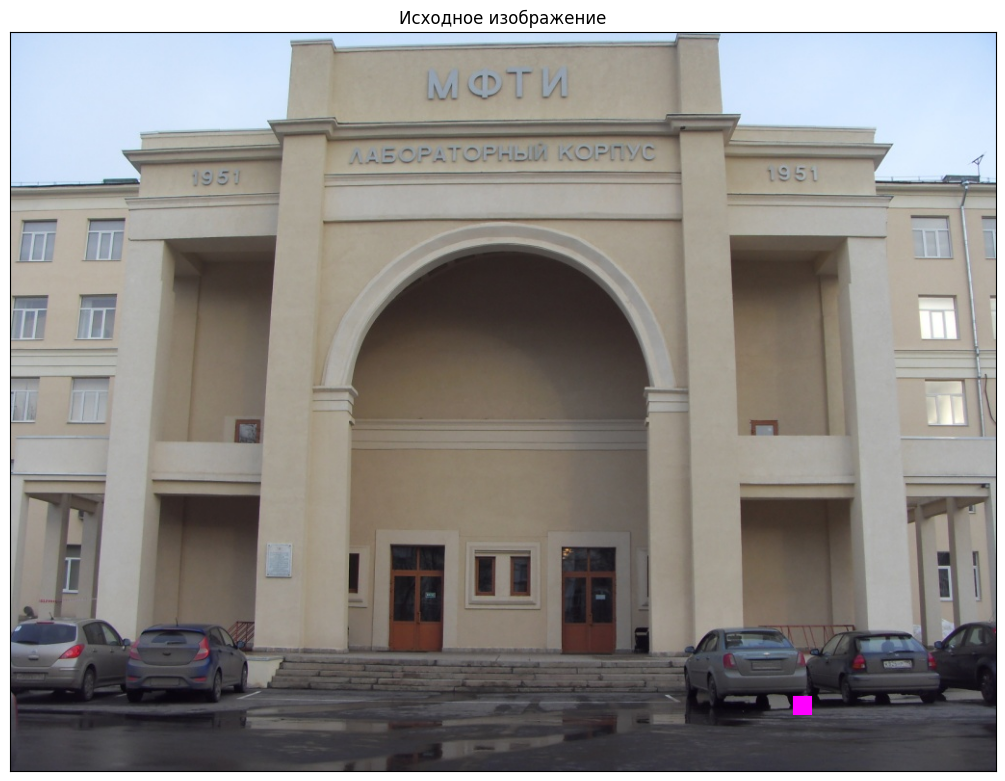

In [240]:
img_copy = image.copy()
img_copy[int(y)-10:int(y)+10, int(x)-10:int(x)+10, :] = [255, 0, 255]

plot_one_image(img_copy)

### Визуализация результатов поиска 

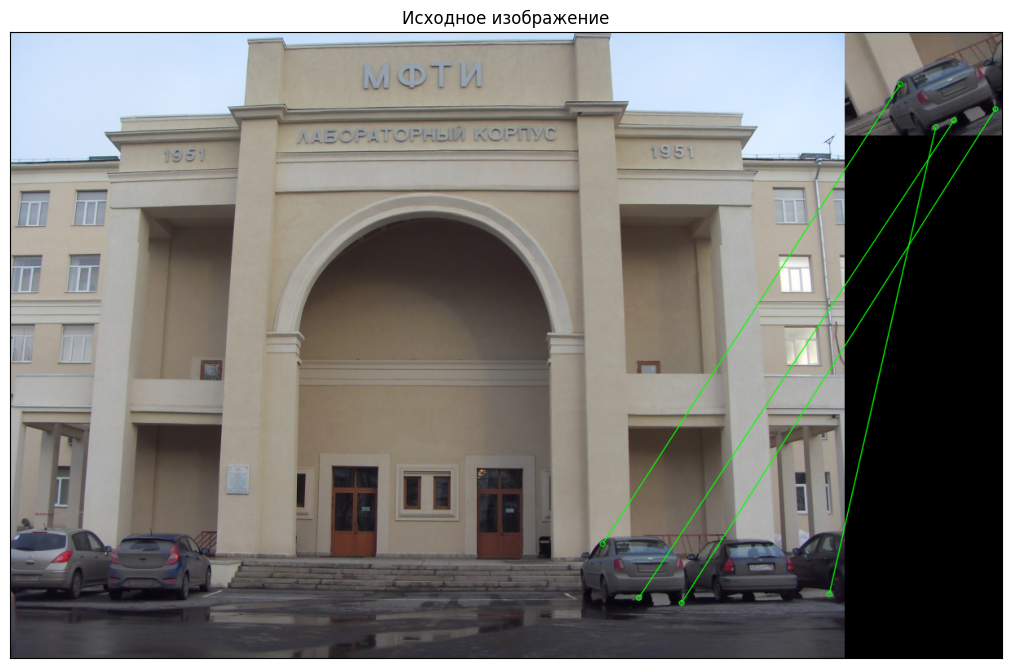

In [241]:
#-- Draw matches
img_matches = np.empty((max(image.shape[0], img_car.shape[0]), image.shape[1] + img_car.shape[1], 3), dtype=np.uint8)

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                  )

cv2.drawMatches(image, keypoints1, img_car, keypoints2, good_matches, img_matches, **draw_params)

#-- Show detected matches
plot_one_image(img_matches)

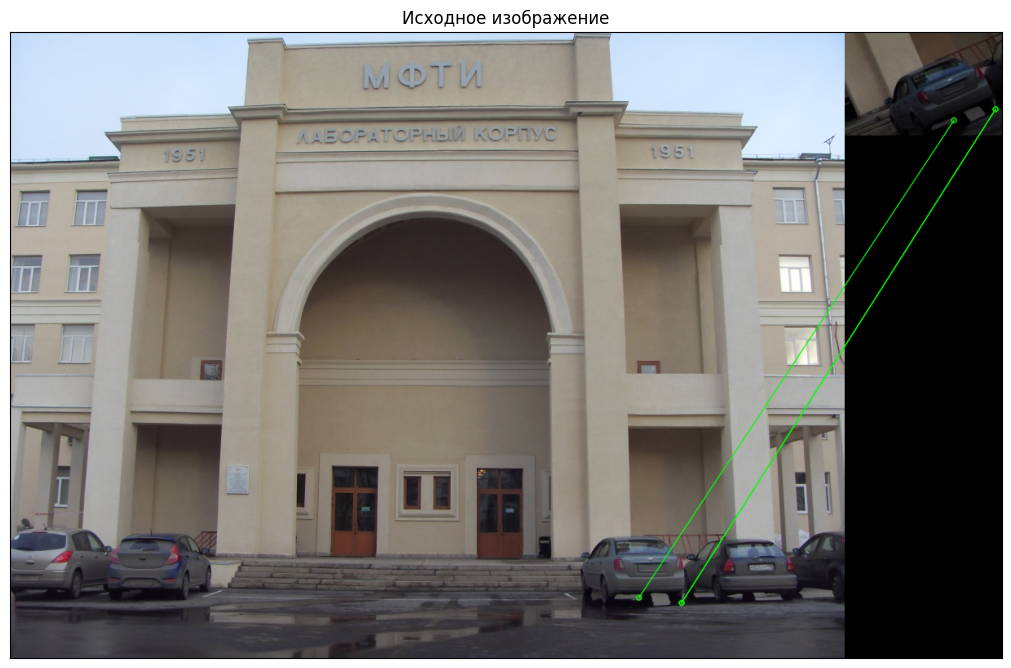

In [242]:
keypoints1, desc1 = detector.detectAndCompute(image, None)
keypoints2, desc2 = detector.detectAndCompute(img_car_new, None)

FLANN_INDEX_KDTREE = 2
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)

ratio_thresh = 0.7
good_matches = []
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
        
img_matches = np.empty((max(image.shape[0], img_car_new.shape[0]), image.shape[1] + img_car_new.shape[1], 3), dtype=np.uint8)

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                  )

cv2.drawMatches(image, keypoints1, img_car_new, keypoints2, good_matches, img_matches, **draw_params)

#-- Show detected matches
plot_one_image(img_matches)

# ORB (Oriented FAST and Rotated BRIEF)

## FAST detection

Выбирается радиус. Если среди пикселей есть n таких, что они все или больше или меньше центрального, то точка считается особой

<table><tr>
    <td> <img src="img/image-102.webp" alt="Drawing" title="Not a key point" alt="Not a key point" style="width: 500px;"/> </td>
    <td> <img src="img/image-103.webp" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>
Не особая и особая точки соответственно

Ориентацию точки можно оценить по центроиду точки $(C_x, C_y): \theta=arctan(C_y / C_x)$

## BRIEF description

Это бинарный дескриптор. При помощи какого то заранее выбранного алгоритма генерирубтся пары пикселей в квадратной окрестности точки. Точки сравниваются, результат сравнения записывается в вектор. Этот вектор и есть дескриптор точки 

<img src="img/brief.png" alt="Drawing" style="width: 500px;"/>

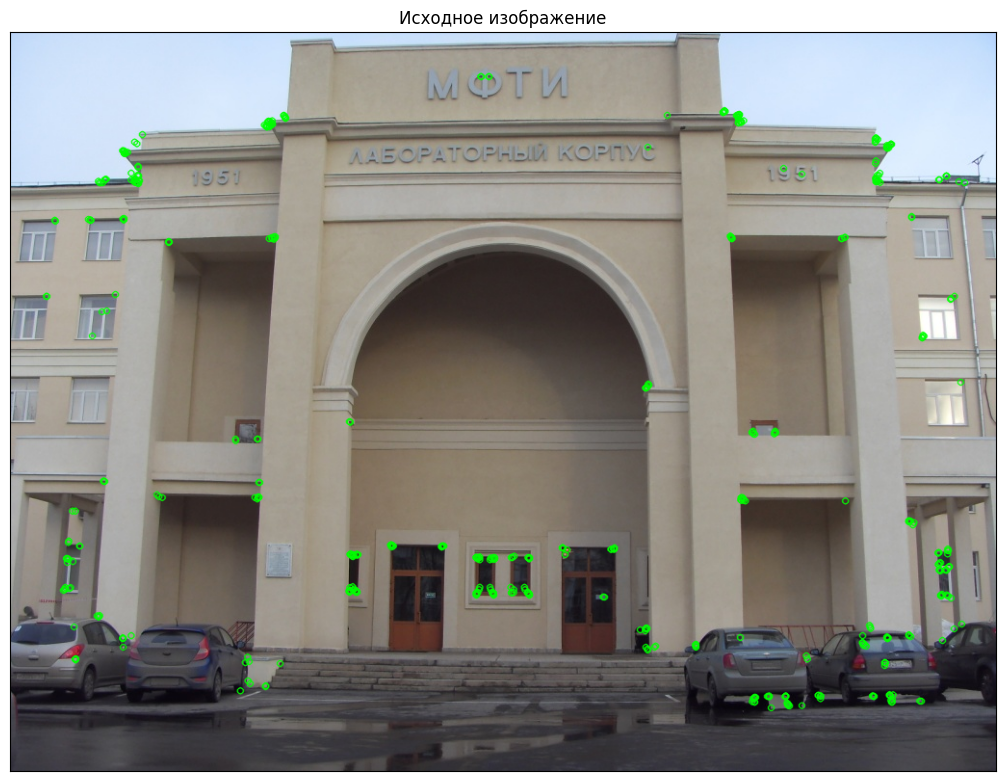

In [243]:
img = image.copy()
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plot_one_image(img2)

### Поиск преобразования
После сопоставления точек остается вопрос: а что же все-таки дальше делать с этими точками? Как сделать панораму?

Сгенерируем несоклько точек и преобразование к ним

[[ 0.73723684  0.68829172 50.        ]
 [-0.51621879  0.98298245 40.        ]
 [ 0.          0.          1.        ]]


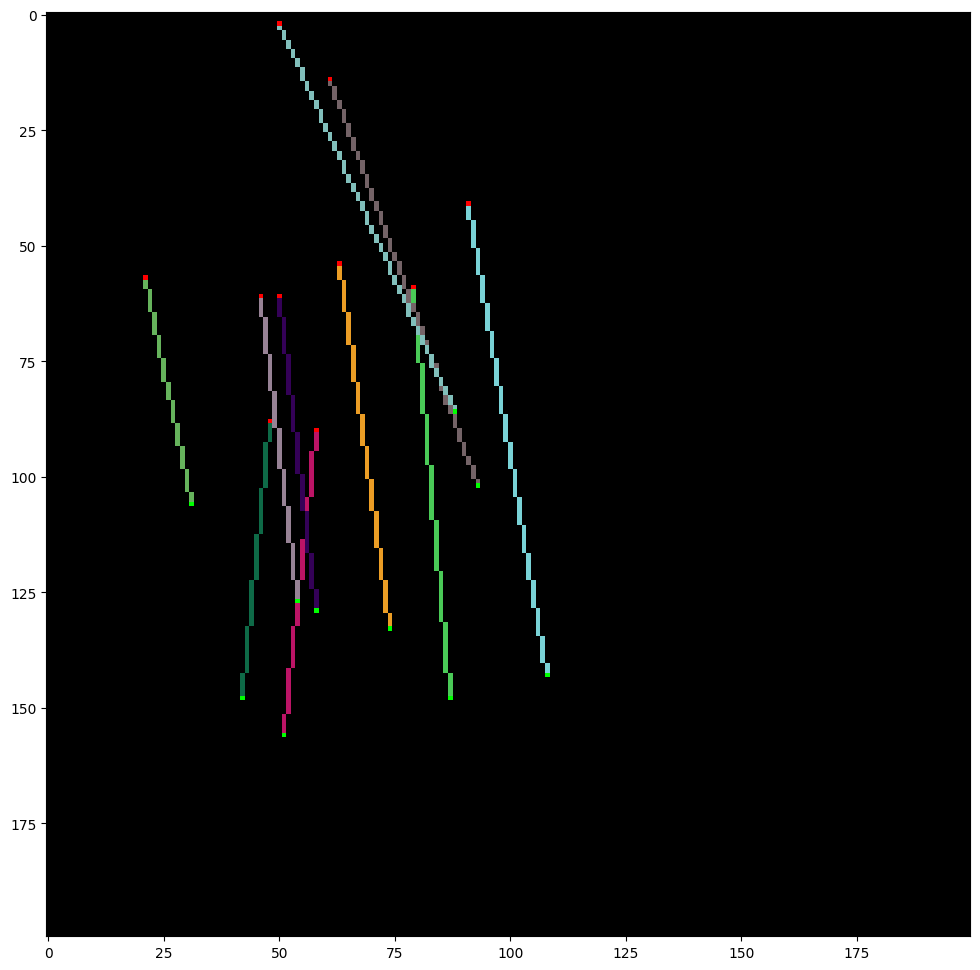

In [244]:
import warnings
warnings.filterwarnings(action='ignore')

def generate_point():
    return np.array([np.random.randint(0, 100), np.random.randint(0, 100), 1]).astype(int)

def draw_points(points, tranformed_points):
    black_canvas = np.zeros((200, 200, 3), dtype=np.uint8)
    np.random.seed(42)

    for i, j in zip(points, tranformed_points):
        cv2.line(black_canvas, (i[1], i[0]), (j[1], j[0]), np.random.random_integers(0, 255, 3).astype(int).tolist(),1)


    black_canvas[points[:, 0], points[:, 1]] = (255, 0, 0)
    black_canvas[tranformed_points[:, 0], tranformed_points[:, 1]] = (0, 255, 0)
    return black_canvas

def apply_transformation(transform_mat, points):
    transformed_points = (transform_mat @ points.T).T
    transformed_points = np.divide(transformed_points.T, transformed_points[:, 2]).T
    # transformed_points = np.round(transformed_points).astype(int)
    return transformed_points

points = np.array([generate_point() for _ in range(10)])

angle = np.deg2rad(-35)
rot_mat = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
scale_mat = np.array([[0.9, 0], [0, 1.2]])
shift_mat = np.array([50, 40])
transform_mat = np.concatenate([rot_mat @ scale_mat, shift_mat[None].T], axis=1)
transform_mat = np.concatenate([transform_mat, np.array([0, 0, 1])[None]], axis=0)
print(transform_mat)


transformed_points = np.round(apply_transformation(transform_mat, points)).astype(int)

black_canvas = draw_points(points, transformed_points)

fig = plt.figure(figsize=(12, 12))
plt.imshow(black_canvas)

### Добавим еще пару точек как шум

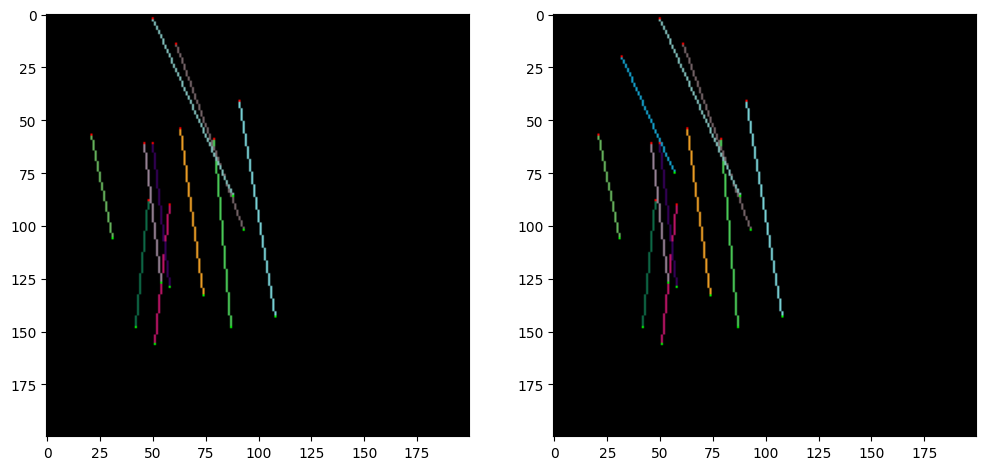

In [245]:
points = np.concatenate([points, generate_point()[None]], axis=0)
transformed_points = np.concatenate([transformed_points, generate_point()[None]], axis=0)

black_canvas_mod = draw_points(points, transformed_points)

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(black_canvas)
ax[1].imshow(black_canvas_mod)

Хотим восстановить преобразование. Правда, будем считать что неизвестно какое преобазование было.

Поэтому попробуем разные преобразования: смещение, афинное преобразование, гомографию с разными функциями расстояний

In [246]:
from scipy.optimize import minimize


def loss_func(loss, construction, orig, ref):
    def f(x):
        transformation = f.construction(x)
        transformed_points = apply_transformation(transformation, f.orig)
        return f.loss(transformed_points, f.ref)
    f.loss = loss
    f.construction = construction
    f.orig = orig
    f.ref = ref
    return f

losses = {
    'l2': lambda x1, x2: np.linalg.norm(x1 - x2),
    'l1': lambda x1, x2: np.sum(np.abs(x1 - x2)),
    'elasticnet': lambda x1, x2, alpha=0.5: alpha * np.sum(np.abs(x1 - x2)) * (1 - alpha) * np.linalg.norm(x1 - x2),
}

def construct_offset_transformation(x):
    transformation = np.eye(3)
    transformation[:2, 2] = x
    return transformation

def construct_affine_transformation(x):
    transformation = np.eye(3)
    transformation[:2] = x.reshape(2, 3)
    return transformation

def construct_homography_transformation(x):
    transformation = np.eye(3).reshape(-1)
    transformation[:8] = x
    return transformation.reshape(3, 3)

def find_transformation(loss, x0):
    res = minimize(loss, x0, method='L-BFGS-B', tol=1e-5, options={'maxiter': 10000})
    return res.x

def find_offset(points, transformed_points, loss_type='l2'):
    loss = loss_func(losses[loss_type], construct_offset_transformation, points, transformed_points)
    x0 = np.zeros(2)
    return construct_offset_transformation(find_transformation(loss, x0))

def find_affine(points, transformed_points, loss_type='l2'):
    loss = loss_func(losses[loss_type], construct_affine_transformation, points, transformed_points)
    x0 = np.zeros(6)
    return construct_affine_transformation(find_transformation(loss, x0))

def find_homography(points, transformed_points, loss_type='l2'):
    loss = loss_func(losses[loss_type], construct_homography_transformation, points, transformed_points)
    x0 = np.zeros(8)
    return construct_homography_transformation(find_transformation(loss, x0))

In [247]:
out_affine = find_affine(points, transformed_points, loss_type='l2')
out_offset = find_offset(points, transformed_points, loss_type='l2')
out_homography = find_homography(points, transformed_points, loss_type='l2')

offset_points = np.round(apply_transformation(out_offset, points)).astype(int)
affine_points = np.round(apply_transformation(out_affine, points)).astype(int)
homography_points = np.round(apply_transformation(out_homography, points)).astype(int)

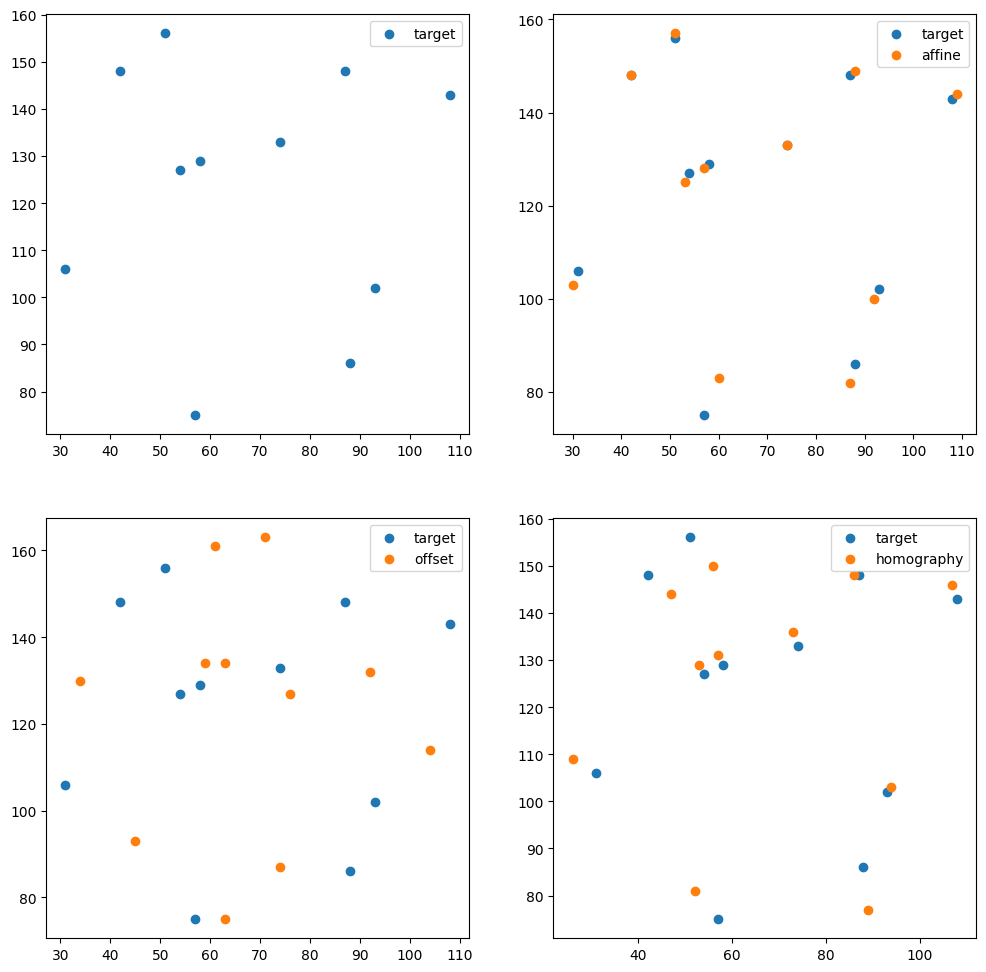

In [248]:
fg, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].scatter(transformed_points[:, 1], transformed_points[:, 0], label='target')
ax[0, 1].scatter(transformed_points[:, 1], transformed_points[:, 0], label='target')
ax[1, 0].scatter(transformed_points[:, 1], transformed_points[:, 0], label='target')
ax[1, 1].scatter(transformed_points[:, 1], transformed_points[:, 0], label='target')
ax[0, 1].scatter(affine_points[:, 1], affine_points[:, 0], label='affine')
ax[1, 0].scatter(offset_points[:, 1], offset_points[:, 0], label='offset')
ax[1, 1].scatter(homography_points[:, 1], homography_points[:, 0], label='homography')
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()

### RANSAC - подход
Данный подход позволяет меньше внимания акцентировать на выборосах и строить более точное преобразование для большинства матчей

Подход заключается в выборе необходимого количество точек для построения преобразования и построении его.

Гомографии тут нет потому что ее слишком сложно руками реализовать с методом RANSAC.

Пример использования гомографии с RANSAC: https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

Также для построения аффинного преобразования при помощи ransac есть библиотечная функция cv2.estimateAffinePartial2D()

In [249]:
from itertools import combinations

losses = {
    'l2': lambda x1, x2: np.linalg.norm(x1 - x2),
    'l1': lambda x1, x2: np.sum(np.abs(x1 - x2)),
    'elasticnet': lambda x1, x2, alpha=0.5: alpha * np.sum(np.abs(x1 - x2)) * (1 - alpha) * np.linalg.norm(x1 - x2),
}


def find_offset_ransac(points, transformed_points, loss_type='l2'):
    best_offset = None
    best_loss = np.inf
    loss_f = losses[loss_type]
    for point, transformed_point in zip(points, transformed_points):
        offset = (transformed_point - point)[:2]
        transformation = construct_offset_transformation(offset)
        tmp = apply_transformation(transformation, points)
        tmp_loss = loss_f(tmp, transformed_points)
        if tmp_loss < best_loss:
            best_loss = tmp_loss
            best_offset = offset
    return construct_offset_transformation(best_offset)


def find_affine_ransac(points, transformed_points, loss_type='l2'):
    best_transformation = None
    best_loss = np.inf
    loss_f = losses[loss_type]
    for pair1, pair2, pair3 in combinations(zip(points, transformed_points), 3):
        points_before = np.concatenate([[pair1[0]], [pair2[0]], [pair3[0]]], axis=0)
        points_after = np.concatenate([[pair1[1]], [pair2[1]], [pair3[1]]], axis=0)
        estimated_transform = points_after.T @ np.linalg.pinv(points_before.T)
        tmp = apply_transformation(estimated_transform, points)
        tmp_loss = loss_f(tmp, transformed_points)
        if tmp_loss < best_loss:
            best_loss = tmp_loss
            best_transformation = estimated_transform
    return best_transformation

In [250]:
out_affine_ransac = find_affine_ransac(points, transformed_points, loss_type='l2')
out_offset_ransac = find_offset_ransac(points, transformed_points, loss_type='l2')

offset_points_ransac = np.round(apply_transformation(out_offset_ransac, points)).astype(int)
affine_points_ransac = np.round(apply_transformation(out_affine_ransac, points)).astype(int)

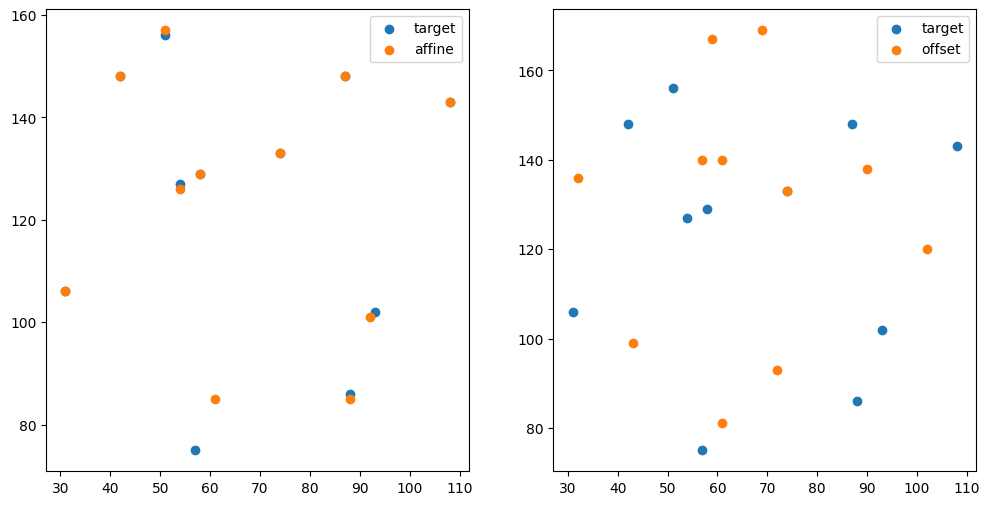

In [251]:
fg, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(transformed_points[:, 1], transformed_points[:, 0], label='target')
ax[1].scatter(transformed_points[:, 1], transformed_points[:, 0], label='target')
ax[0].scatter(affine_points_ransac[:, 1], affine_points_ransac[:, 0], label='affine')
ax[1].scatter(offset_points_ransac[:, 1], offset_points_ransac[:, 0], label='offset')
ax[0].legend()
ax[1].legend()